In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep

/home/opt/python/anaconda3.8_TF2.5/envs/torch_1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([ 0.4571, -0.4636, -0.1729])
tensor([ 0.5388, -0.3970])


In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

In [4]:
estimator = NPE(3, 2, transforms=3, hidden_features=[64] * 3)
estimator

NPE(
  (flow): MAF(
    (transforms): ModuleList(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [0, 1, 2]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=5, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): MaskedLinear(in_features=64, out_features=6, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [2, 1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=5, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Mask

In [5]:
loss = NPELoss(estimator)

In [6]:
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

with tqdm(range(64), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta, x))
            for theta, x in islice(loader, 256)  # 256 batches per epoch
        ])

        tq.set_postfix(loss=losses.mean().item())

100%|██████████| 64/64 [04:49<00:00,  4.53s/epoch, loss=-2.45]


In [23]:
x_star = simulator(torch.tensor([0.0,0.0,0.0]))

estimator.eval()

with torch.no_grad():
    samples = estimator.flow(x_star).sample((2**16,))

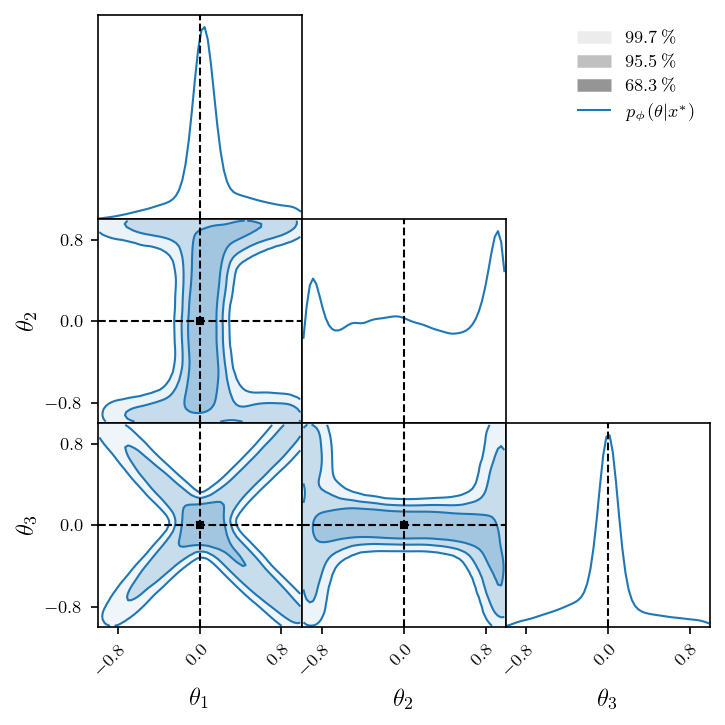

In [24]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, torch.tensor([0.0,0.0,0.0]))

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NRE, NRELoss, MetropolisHastings
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep

estimator1 = NRE(3, 2, hidden_features=[64] * 5)

In [20]:
loss = NRELoss(estimator1)
optimizer = optim.AdamW(estimator1.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator1.train()

with tqdm(range(64), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta, x))
            for theta, x in islice(loader, 256)  # 256 batches per epoch
        ])

        tq.set_postfix(loss=losses.mean().item())

100%|██████████| 64/64 [02:27<00:00,  2.30s/epoch, loss=0.0455]


In [25]:
estimator1.eval()

with torch.no_grad():
    theta_0 = prior.sample((1024,))  # 1024 concurrent Markov chains
    log_p = lambda theta: estimator1(theta, x_star) + prior.log_prob(theta)  # p(theta | x) = r(theta, x) p(theta)

    sampler = MetropolisHastings(theta_0, log_f=log_p, sigma=0.5)
    samples1 = torch.cat(list(sampler(2048, burn=1024, step=4)))

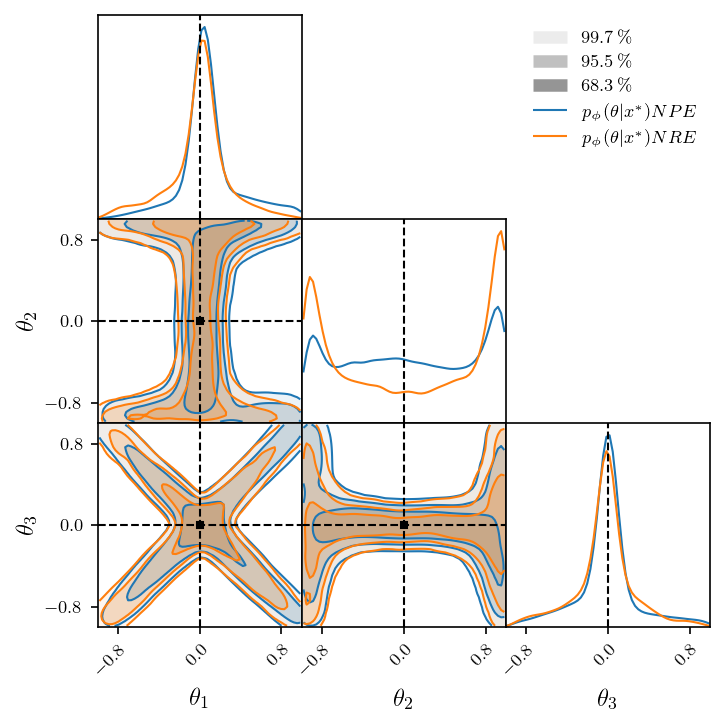

In [26]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings


fig_bilby = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*) NPE$',
    figsize=(4.8, 4.8),
)




fig = corner(
    samples1,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*) NRE$',
    figsize=(4.8, 4.8),
    figure=fig_bilby,
)

mark_point(fig, torch.tensor([0.0,0.0,0.0]))